# RNN Data

### Dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras import Sequential



from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = '/Users/kieran/Desktop/Le Wag/train1_update.csv'
df = pd.read_csv(dataset)
display(df)

,id,cycle,setting1,setting2,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Nc_Physical_core_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,NRc_Corrected_core_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [3]:
features = df.drop(['id','cycle','RUL'], axis=1)
target = df['RUL']

### Scaler

In [4]:
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

### Sequences

In [5]:
sequence_length = 10
sequences = []
rul_values = []

### Grouped by engines

In [6]:
for engine_id in df['id'].unique():
    engine_data = features_norm[df['id'] == engine_id]
    engine_rul = target[df['id'] == engine_id]
    
    for i in range(len(engine_data) - sequence_length + 1):
        sequences.append(engine_data[i:i + sequence_length])
        rul_values.append(engine_rul.iloc[i + sequence_length - 1])

sequences = np.array(sequences)
rul_values = np.array(rul_values)

### Split

In [8]:
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = rul_values[:split_index], rul_values[split_index:]

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15784, 10, 16), (3947, 10, 16), (15784,), (3947,))

### RNN Model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

def build_rnn_model(input_shape):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    return model

# Build the model
input_shape = (sequence_length, features.shape[1])
model = build_rnn_model(input_shape)

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        13,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,651 (131.45 KB)

 Trainable params: 33,651 (131.45 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 91.6981 - val_loss: 94.4394
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 78.0937 - val_loss: 85.9907
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71.6461 - val_loss: 79.4832
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 65.6046 - val_loss: 74.5766
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 61.2693 - val_loss: 70.9343
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 57.6753 - val_loss: 68.2698
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55.5520 - val_loss: 66.3563
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 54.8124 - val_loss: 65.0278
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 53.2057 - val_loss: 64.1606
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 52.5678 - val_loss: 63.6051
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 52.6205 - val_loss: 63.2675
Epoch 12/20
247/247 ━━━━━━━━━━

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.6384
Test Loss: 62.7529182434082
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 63.25125192623366
Mean Squared Error (MSE): 6213.461543093695
Root Mean Squared Error (RMSE): 78.82551327516805


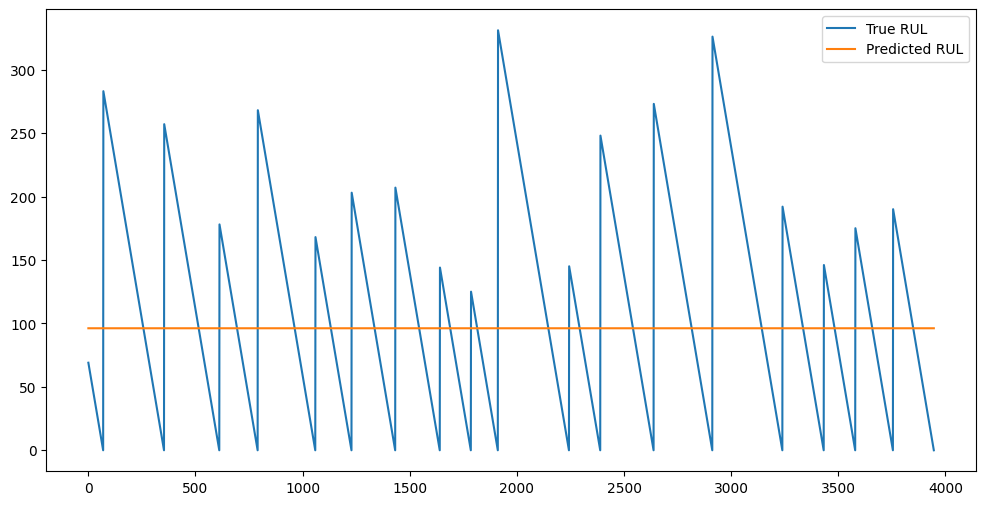

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Compare predictions to the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.legend()
plt.show()